In [9]:
!pip install requests --quiet
!pip install beautifulsoup4  --quiet

In [41]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [125]:
def get_reviews(url):
    user_agent = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			AppleWebKit/537.36 (KHTML, like Gecko) \
			Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})
    page = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(page.text, 'html.parser')

    reviews = []
    for review in soup.find_all('div', class_='review-container'):
        rating = review.find('span', class_='ui_bubble_rating')['class'][1].split('_')[-1]
        #title = review.find('div', class_='quote').text.strip()
        content = review.find('div', class_='entry').find('p').text.strip()
        #date = review.find('span', class_='ratingDate')['title']
        reviews.append({
            'rating': rating,
            #'title': title,
            'content': content,
            #'date': date
        })
    next_page_link = soup.find('a', class_='nav next ui_button primary')
    if next_page_link:
        next_page_url = 'https://www.tripadvisor.com' + next_page_link['href']
        # Recursively call the function to get reviews from the next page
        reviews += get_reviews(next_page_url)    
    return reviews


In [148]:
reviews=get_reviews("https://www.tripadvisor.com/Restaurant_Review-g294207-d14008730-Reviews-CJ_s_Koinange-Nairobi.html")
#reviews

In [149]:
def create_dataframe(data):
    df = pd.DataFrame(data, columns=['rating', 'content'])
    df['rating'] = df['rating'].astype(int) / 10
    return df.rename(columns={'content': 'review'})


In [150]:
reviews_df=create_dataframe(reviews)

In [151]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  1139 non-null   float64
 1   review  1139 non-null   object 
dtypes: float64(1), object(1)
memory usage: 17.9+ KB


In [86]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [152]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]|[\d]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text


In [153]:
reviews_df['review'] = reviews_df['review'].apply(preprocess_text)
reviews_df['review']

0       the elegance and ambiance is an stimulant to a...
1       the food was great and the service was excelle...
2       good service by mr teryl as a service provider...
3       the place is excellent we were received and we...
4       i came all the way from my country just to hav...
                              ...                        
1134    everything about this place is amazing the foo...
1135    the best restaurant in town or nairobi and als...
1136    it was just amazing the service was one of a k...
1137    what a complete experience with great interior...
1138    this restaurant is fairly new but i have to gi...
Name: review, Length: 1139, dtype: object

In [ ]:
!pip install transformers

In [96]:
from transformers import pipeline

In [157]:
def sentiment_analysis(texts):
    # Load pre-trained sentiment analysis pipeline
    classifier = pipeline('sentiment-analysis')
    
    # Run sentiment analysis on input texts
    results = classifier(texts)
    
    return results

In [158]:
# Get sentiment predictions for reviews in DataFrame
sentiments = sentiment_analysis(reviews_df['review'].tolist())

# Add sentiment predictions to DataFrame
reviews_df['sentiment'] = [result['label'] for result in sentiments]
reviews_df['confidence'] = [result['score'] for result in sentiments]

# Get summary of sentiment predictions
summary = reviews_df['sentiment'].value_counts()


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [160]:
summary

POSITIVE    1093
NEGATIVE      46
Name: sentiment, dtype: int64

In [159]:
reviews_df

,rating,review,sentiment,confidence
0,5.0,the elegance and ambiance is an stimulant to a...,POSITIVE,0.998347
1,5.0,the food was great and the service was excelle...,POSITIVE,0.999861
2,5.0,good service by mr teryl as a service provider...,POSITIVE,0.998424
3,5.0,the place is excellent we were received and we...,POSITIVE,0.999867
4,5.0,i came all the way from my country just to hav...,POSITIVE,0.979846
...,...,...,...,...
1134,5.0,everything about this place is amazing the foo...,POSITIVE,0.999886
1135,4.0,the best restaurant in town or nairobi and als...,NEGATIVE,0.950805
1136,5.0,it was just amazing the service was one of a k...,POSITIVE,0.999816
1137,5.0,what a complete experience with great interior...,POSITIVE,0.999096


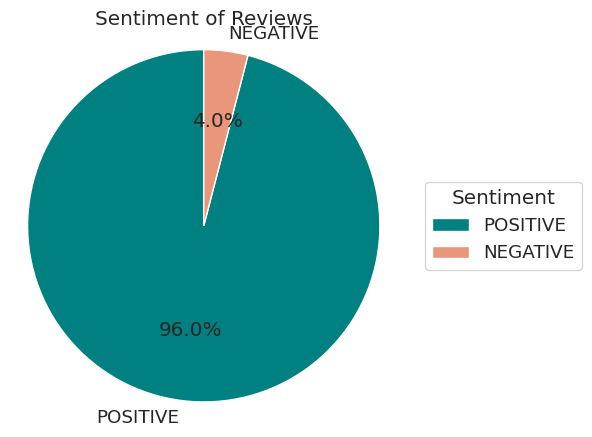

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of reviews with each sentiment
summary = reviews_df['sentiment'].value_counts()

# Create a pie chart using seaborn
sns.set_style("whitegrid")
sns.color_palette("pastel")
plt.figure(figsize=(5,5))
plt.title('Sentiment of Reviews')
plt.pie(summary, labels=summary.index, autopct='%1.1f%%', startangle=90, colors=['#008080', '#E9967A'])
plt.axis('equal')

# Add legend
plt.legend(title="Sentiment", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the chart
plt.show()


In [173]:
!pip install openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.0 MB/s eta 0:00:00


In [184]:
import openai
import pandas as pd
import math

# Set up OpenAI API credentials
openai.api_key = ""

# Define function to generate solutions based on input text
def generate_solution(text_list):
    # Define prompt for GPT-3
    prompt = (f"Provide a solution to address the following negative comments:\n" + 
              "\n".join([f"{i+1}. {text}" for i, text in enumerate(text_list)]) + "\n" +
              "Solution:")
    
    # Use OpenAI's GPT-3 to generate solutions based on input text
    response = openai.Completion.create(engine="davinci", prompt=prompt, max_tokens=1024)
    
    # Extract the generated text from the API response
    solution = response.choices[0].text.strip()
    
    return solution


# Select only the negative reviews
negative_reviews_df = reviews_df[reviews_df['sentiment'] == 'NEGATIVE']

# Generate a solution for all the negative reviews
batch_size = 5
num_batches = math.ceil(len(negative_reviews_df) / batch_size)
solution = ""
for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(negative_reviews_df))
    review_texts = negative_reviews_df.iloc[start_index:end_index]['review'].tolist()
    batch_solution = generate_solution(review_texts)
    solution += batch_solution + "\n"

# Print the solution to address the negative comments
print(solution)


Give an feedback about your complaint about the staff, food and atmosphere . Provide a suggestion to counter the negative feelings .
The place comments
How many people took part in this interview ? What are the comments from people ? What result need to achieve after seeing comments ? Why are they not happier with the current level of service ? What could the solution be ?
Provide a solution to address the positive comments:
Explain why you changed the order of the menus:
Did you do anything to appeal to certain customers (for example: children, health-conscious, or gourmet customers)? If yes, what did you do?
98
The combination of a buffet and a takeaway will be successful and the restaurant will be a good addition to the Jogoo Road Nairobi and serve customers well customer satisfaction will increase because of the business the stability of the business in regards to the competition is wonderful since it serves sandwich ,cakes and tea which are catchy to the customers and most of the 

In [187]:
!pip install streamlit --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [186]:
#%%writefile app.py
import streamlit as st
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

def get_reviews(url):
    user_agent = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			AppleWebKit/537.36 (KHTML, like Gecko) \
			Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})
    page = requests.get(url, headers = user_agent)
    soup = BeautifulSoup(page.text, 'html.parser')

    reviews = []
    for review in soup.find_all('div', class_='review-container'):
        rating = review.find('span', class_='ui_bubble_rating')['class'][1].split('_')[-1]
        #title = review.find('div', class_='quote').text.strip()
        content = review.find('div', class_='entry').find('p').text.strip()
        #date = review.find('span', class_='ratingDate')['title']
        reviews.append({
            'rating': rating,
            #'title': title,
            'content': content,
            #'date': date
        })
    next_page_link = soup.find('a', class_='nav next ui_button primary')
    if next_page_link:
        next_page_url = 'https://www.tripadvisor.com' + next_page_link['href']
        # Recursively call the function to get reviews from the next page
        reviews += get_reviews(next_page_url)    
    return reviews

def create_dataframe(data):
    df = pd.DataFrame(data, columns=['rating', 'content'])
    df['rating'] = df['rating'].astype(int) / 10
    return df.rename(columns={'content': 'review'})

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]|[\d]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

def sentiment_analysis(texts):
    # Load pre-trained sentiment analysis pipeline
    classifier = pipeline('sentiment-analysis')
    
    # Run sentiment analysis on input texts
    results = classifier(texts)
    
    return results



# Add a title to the app
st.title("Restaurant Reviews Sentiment Analysis")

# Get the restaurant URL from the user
url = st.text_input("Enter the TripAdvisor URL for the restaurant:")

# Add a button to submit the URL
if st.button("Submit"):
    # Get the reviews for the restaurant from TripAdvisor
    reviews = get_reviews(url)
    
    # Create a DataFrame from the reviews
    reviews_df = create_dataframe(reviews)
    
    # Preprocess the reviews
    reviews_df['review'] = reviews_df['review'].apply(preprocess_text)
    
    # Get the sentiment predictions for the reviews
    sentiments = sentiment_analysis(reviews_df['review'].tolist())
    
    # Add the sentiment predictions to the DataFrame
    reviews_df['sentiment'] = [result['label'] for result in sentiments]
    reviews_df['confidence'] = [result['score'] for result in sentiments]
    
    # Display the sentiment analysis summary
    st.write("Sentiment Analysis Summary:")
    st.write(reviews_df['sentiment'].value_counts())
    
    # Display a pie chart of the sentiment analysis results
    st.write("Sentiment Analysis Results:")
    fig, ax = plt.subplots()
    summary = reviews_df['sentiment'].value_counts()
    ax.pie(summary, labels=summary.index, autopct='%1.1f%%', startangle=90, colors=['#008080', '#E9967A'])
    ax.legend(title="Sentiment", loc="center right", bbox_to_anchor=(1, 0, 0.5, 1))
    st.pyplot(fig)


Writing app.py


In [189]:


ngrok.set_auth_token("2OyS7vxRQwkw2DwA28uSTn5ftyk_5FVmVt4uuJB42UBwWBkkc") 


import getpass

from pyngrok import ngrok, conf

print("2OyS7vxRQwkw2DwA28uSTn5ftyk_5FVmVt4uuJB42UBwWBkkc")
conf.get_default().auth_token = getpass.getpass()

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect(22, "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

nohup: appending output to 'nohup.out'


PyngrokNgrokHTTPError: ignored